## Operating a fleet of aircrafts with RL: Proof of Concept with a 2-aircraft fleet


This notebook describes a proof of concept showing how to optimise the operation and management of a fleet of aircrafts (mission assignment + maintenance scheduling) using Reinforcement Learning (RL) methods.

#### To install

To install the necessary python libraries, open the Anaconda Prompt, drive to the directory where the `environment.yml` file is and run the following command:

conda env create -f environment.yml -n mlenvgpu
This will create a virtual environment with all the required packages (tensorflow, pytorch, gym etc...). Then activate the environment with `conda activate mlenvgpu`.
#### Initial settings

In [74]:
%load_ext autoreload
%autoreload 2

# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime, timedelta
from scipy import stats
import random
from collections import deque
import time
import copy
import json
import itertools
import shutil
import matplotlib.patches as mpatches
# Pytorch
import torch
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:',device)
print(torch.cuda.get_device_name(0))

# plotting parameters
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# import environment module
import opfleet_env as opfleet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda
Quadro RTX 8000


## 1. Environment description

### 1.1. Environment Parameters
The environment is flexible and allows several variables to be adjusted, like the number of tail numbers in the fleet, prescribed daily missions, initial state of the fleet, reward function etc... All of this is defined in the `parameters` dictionary.

In this simple proof-of-concept we start with a fleet of 2 aircrafts with 2 missions to be completed each day:

In [75]:
run_name = 'example_test'
# create folder to store the outputs 
fp_outputs = os.path.join(os.getcwd(),run_name)
if not os.path.exists(fp_outputs): os.makedirs(fp_outputs)

# store parameters file so it can be loaded for successive runs
if os.path.exists(os.path.join(fp_outputs,'params.pkl')):
    with open(os.path.join(fp_outputs,'params.pkl'),'rb') as f:
        params = pickle.load(f)    
    print('loaded existing params file')
else:
    print('created new params file at %s'%fp_outputs)
    params = {
        
        # Paris law parameters for degradation model
        'b': 76.2/1000,         # body width converted to metres
        'm': 2.9,               # Paris exponent
        'C_median': 8.586e-11+2*0.619e-11,  # median of Paris coefficient C
        'C_std': 3*0.619e-11,     # std of Paris coefficient C 
    
        # initial and critical crack length
         'a0': 9/1000,          # 9mm as in Virkler data converted to metres
         'amax': (76.2/2)/1000, # critical at one third of body width
        
        # assume that cyclic stress frequency is 0.65 Hz (20Hz in Virkler data)
        'f0': 5,
        
        # assume that different maneuvers have different stress range (ds)
        # maneuver m1: ds = 30 MPa (level fly), ds = stress range/amplitude
        # maneuver m2: ds = 50 MPa (take-off & land), ds=48.26 in Virkler data
        # maneuver m3: ds = 70 MPa (barrel rotate)
        # maneuver m4: ds = 90 MPa (pull up/down & turn)
        # maneuver m5: ds = 110 MPa (vertical up/down)
        'maneuvers': [30, 50, 70, 90, 110], # ds for each maneuver
        
        # define 5 types of missions, where different maneuvers are performed
        # Mission  #1: m1(3600sec) - m2(60sec) - m3(40sec) - m4(60sec) - m5(20sec)
        # Mission  #2: m1(4000sec) - m2(60sec) - m3(60sec) - m4(80sec)
        # Mission  #3: m1(3000sec) - m2(60sec) -             m4(70sec) - m5(40sec)
        # Mission  #4: m1(2600sec) - m2(60sec) - m3(30sec) -             m5(10sec)
        # Mission  #5: m1(4500sec) - m2(60sec) -             m4(60sec) - m5(80sec)
        # duration in s:      M1, M2, M3, M4, M5
        'missions': {'M1': [2600, 60, 30, 0 , 10],
                     'M2': [4500, 60, 0 , 60, 80]},    
                                      
        # fleet composition
        'n_tail': 2, 
        # tail numbers in each squadron (based on age)
        'groups_tail': {'group1':np.arange(1),
                        'group2':np.arange(1,2)},
        
        # episode timeframe (Monday to Friday)
        'date_start': datetime(2018,1,1),   # starting date
        'date_end': datetime(2023,1,1),     # ending date
        
        # prescribed missions, number of daily missions and composition
        'missions_per_day': 2,              # how many missions are prescribed each day
        'mission_composition': 'fixed-constant',  # 3 options for the mission composition:
                                            # 'fixed-constant': fixed number of mission and constant composition (e.g., one of each)
                                            # 'fixed-mixed':    fixed number of missions but random composition  
                                            # 'random':         random number of missions and random composition           
        
        # reward function [-1 per day in maintenance, 0 standby]
        'reward_scheme': 'mission-based', # 3 implemented reward schemes
                                     # 'constant': constant reward [+1 per mission flown]
                                     # 'damage-based': reward based on damage caused
                                     # 'mission-based': reward based on mission type
        # if 'mission-based', specify the rewards
        'reward_per_mission': [1,2], # respective rewards for [M1,M2,M3,M4,M5]

        # maintenance levels      duration repair   cost
        'preventive_maintenance': [5,      30,     10],
        'corrective_maintenance': [5,     30,      100],
        
        # crack length discretation
        'damage_levels': 10,
        }
    
    # generate C coefficients or load if already exists
    if os.path.exists(os.path.join(fp_outputs,'C_values.pkl')):
        with open(os.path.join(fp_outputs,'C_values.pkl'),'rb') as f:
            params['C'] = pickle.load(f)          
        print('C-values were loaded from file')
    else:
        # params['C'] = params['C_median'] + params['C_std']*np.random.normal(size=params['n_tail'])
        params['C'] = np.array([7e-11, 1.3e-10])
        with open(os.path.join(fp_outputs,'C_values.pkl'),'wb') as f:
            pickle.dump(params['C'],f)
    
    # save params into a file
    with open(os.path.join(fp_outputs,'params.pkl'),'wb') as f:
        pickle.dump(params,f)

loaded existing params file


2610 missions generated from 01-01-2018 to 30-12-2022 (1305 days)
Number of aircrafts: 2
Number of actions per tail number: 4
['M1', 'M2', 'SB', 'MT']
Mission mode: fixed-constant
Reward scheme: mission-based
Cyclic stress frequency: 5 Hz
Preventive maintenance: 5 days 30 mm 10$
Corrective maintenance: 5 days 30 mm 100$
Number of possible actions: 16
Number of possible states: 81


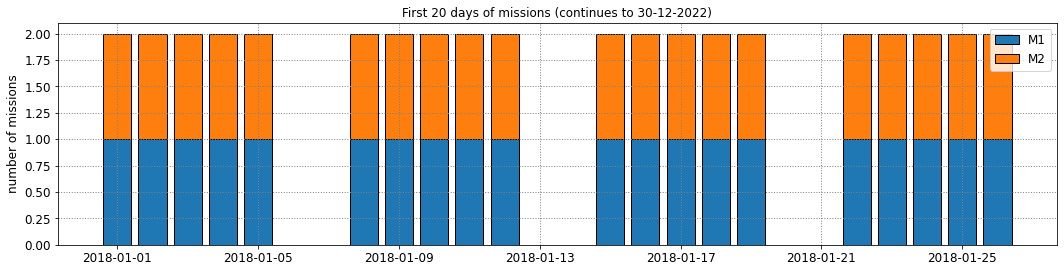

In [76]:
# create the opfleet Env class (contains all the logic to manage the fleet)
env = opfleet.Env(params, verbose=True)

### 1.3. Degradation model and C-values

Each tail number draws a C-value (Paris coefficient) from the specified normal distribution, which will determine how rapidly it degrades following Paris equation.

C-values for the tail numbers:
[7.24924121e-11 1.21948281e-10]
using provided C values


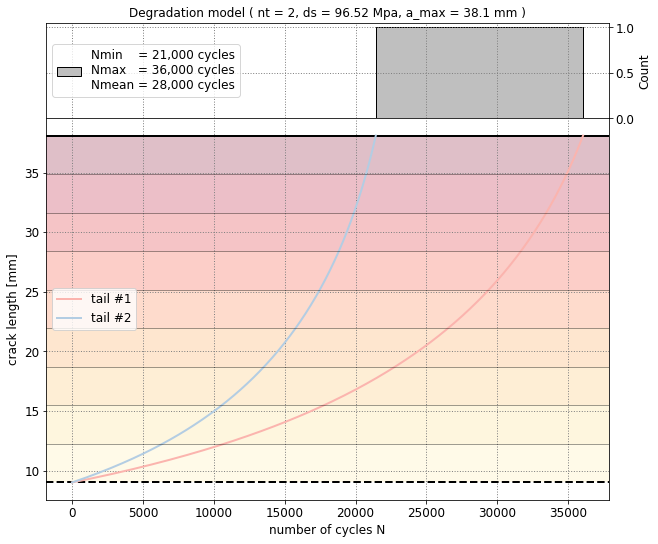

In [7]:
print('C-values for the tail numbers:'); print(params['C'])
ds = 48.26*2                # stress range in MPa, depends on manoeuvre
nt = 68*3                   # number of trajectories
a_max = 76.2/2              # maximum crack length allowable in mm

N, N_min, a, C, fig = opfleet.degradation_model(ds,nt,a_max,2,C=params['C'],
                                                levels=params['damage_levels'])
fig.savefig(os.path.join(fp_outputs,'degradation_paths.jpg'))

### 1.4. Reward function
The agent or operator receives positive rewards when missions are completed, and negative rewards for stand-by or maintenance. The reward function can be summarised as follows:
-  +1 for flying Mission 1 (M1)
-  +1 for flying Mission 2 (M2)
-  -1 for stand-by
-  -10 for preventive maintenance (+ 5 days unavailable)
-  -100 for corrective maintenance (if failure threshold is reached)

## 2. Policy Optimisation with Q-learning

In this section we run Q-learning to find the optimal policy for this environment.

In [77]:
# create folder to store results
fp_init = os.path.join(fp_outputs,'env_2tails_10levels')
if not os.path.exists(fp_init): os.makedirs(fp_init)

# initialise environment
env = opfleet.Env(params, verbose=False)

### 2.1. Search parameters

We need to set a few parameters to run the search according to the *epsilon-greedy* search policy:
- the `number of episodes` over which to run the search
- the decay of the exploration rate (`epsilon`) and learning rate (`alpha`): these are set to decay as the number of episodes increase so that as the Qtable gets more experience in the environment it doesn't choose random action any more and the updates get smaller and smaller to ensure policy convergence.
- the discount factor `gamma`: value between 0 and 1 determining by how much future rewards are discounted.

Also, for we start each episode in a random state to help the exploration of the state space.

max: 38.1 min: 9.0


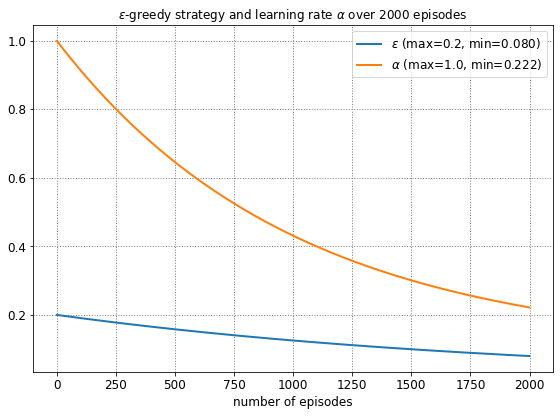

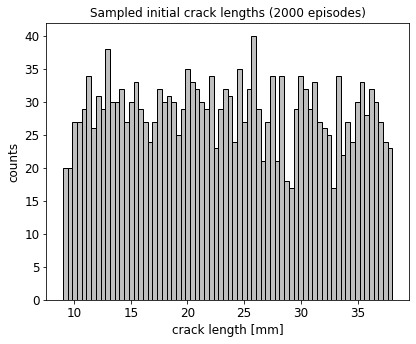

In [71]:
# set settings for environment and create folder in directory
fp = os.path.join(fp_init,'Qtable_run1')
if not os.path.exists(fp): os.makedirs(fp)

# training parameters
train_params = {
    'n_episodes': 2000,         # number of episodes for the search
    'max_epsilon': 0.2,         # max epsilon at the start of the search
    'min_epsilon': 0.01,        # minimum exploration rate
    'decay_epsilon': 0.0005,    # epsilon decay
    'max_alpha': 1,            # initial alpha value
    'min_alpha': 0.1,          # min alpha
    'decay_alpha': 0.001,       # alpha decay
    'gamma': 0.9,               # discount factor
    'saving_step': 10,          # how often to save the model
    'n_decisions': 1300,         # number of decisions per mini-episode
}

# plot epsilon and alpha decay curves
fig, epsilons, alphas = opfleet.plot_eps_alpha(train_params)
fig.savefig(os.path.join(fp,'epsilon_greedy_search.jpg'))

# store parameters in a text file for reference
with open(os.path.join(fp,'train_params.txt'),'w') as f:
    json.dump(train_params,f,indent=4)

# draw initial states for each episode from exponential distribution
nei = train_params['n_episodes']
crack_lengths = np.empty((nei,env.n_tail))
for k in range(env.n_tail):
    crack_lengths[:,k] = np.random.uniform(env.a0*1000,env.amax*1000,nei)
# random_exp = stats.truncexpon(env.amax*1000,scale=10)
# for k in range(env.n_tail):
#     sampled_cracks = env.amax*1000-random_exp.rvs(nei)
#     sampled_cracks = sampled_cracks[sampled_cracks>=env.a0*1000]
#     crack_lengths[:,k] = np.random.choice(sampled_cracks,nei)
train_params['crack_lengths'] = crack_lengths

# plot the sampled crack lengths
fig,ax = plt.subplots(1,1,figsize=(6,5),tight_layout=True,sharex=True)
ax.hist(crack_lengths[:,0],bins=70,fc='0.75',ec='k')
ax.set(title='Sampled initial crack lengths (%d episodes)'%nei,
        xlabel='crack length [mm]',ylabel='counts');
print('max: %.1f min: %.1f'%(np.max(crack_lengths),np.min(crack_lengths)))
fig.savefig(os.path.join(fp,'initial_states_supervised.jpg'))

### 2.2. Run Q-learning policy search

In [ ]:
# search the optimal policy
env = opfleet.Env(params)
q_table = dict([])
# states = np.arange(1,10)
# for s in states:     
#     for ss in states:
#         for sss in states:
#             state = np.zeros(3)
#             state[0] = s
#             state[1] = ss
#             state[2] = sss
#             state = '[%d %d %d]'%(state[0],state[1],state[2])
#             q_table[state] = np.random.uniform(-10,10,len(env.possible_actions))
q_table = opfleet.train_qtable(env,q_table,train_params,fp)

### 2.3. Visualise optimal policy

loaded model 1999
qtable -> total rewards = 1999


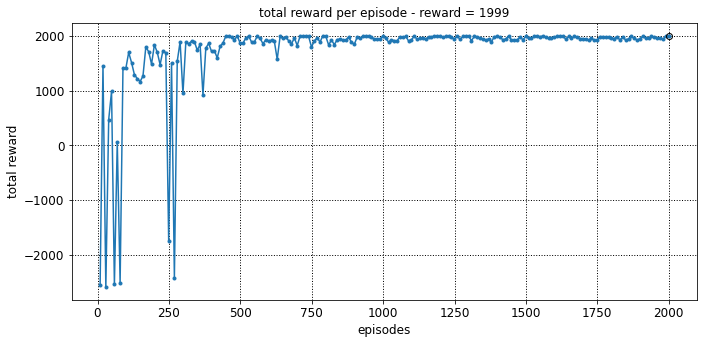

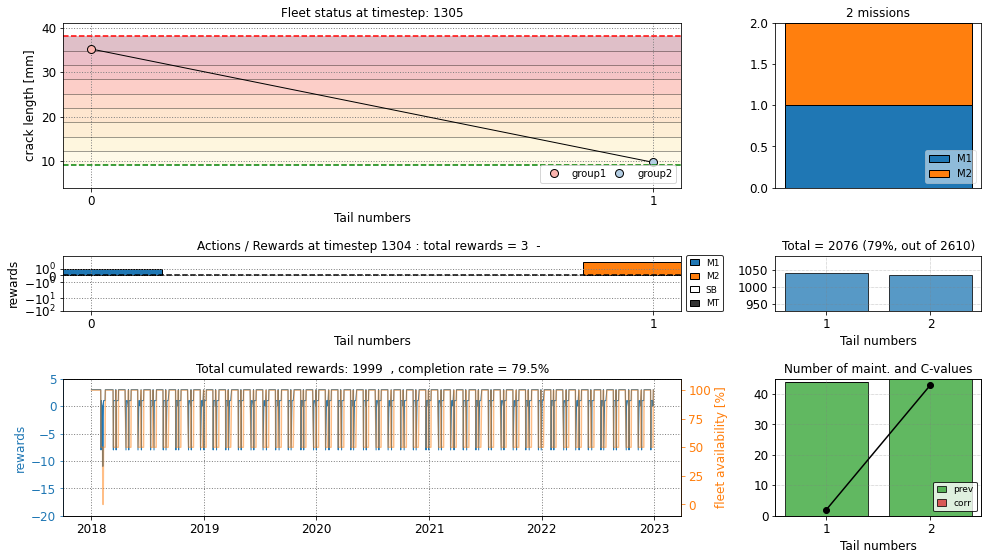

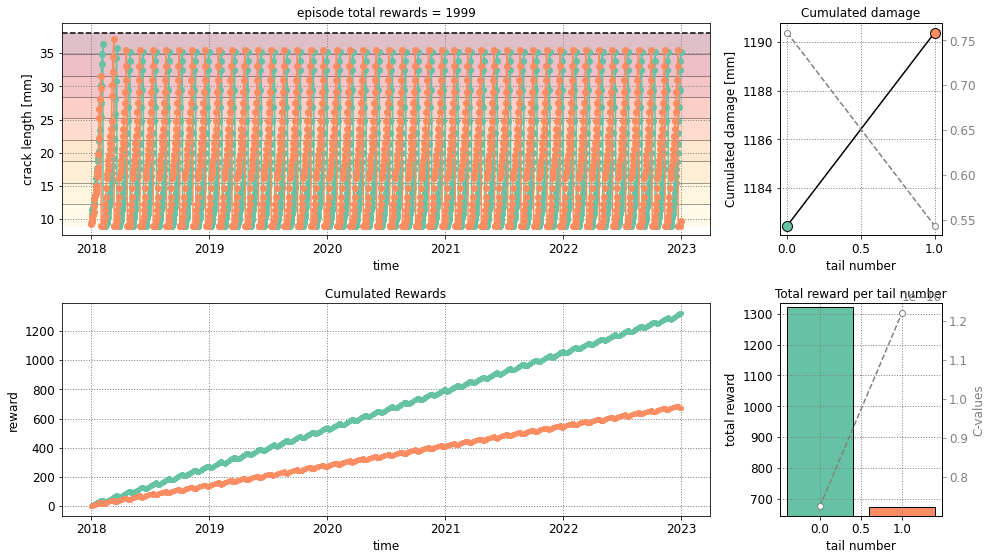

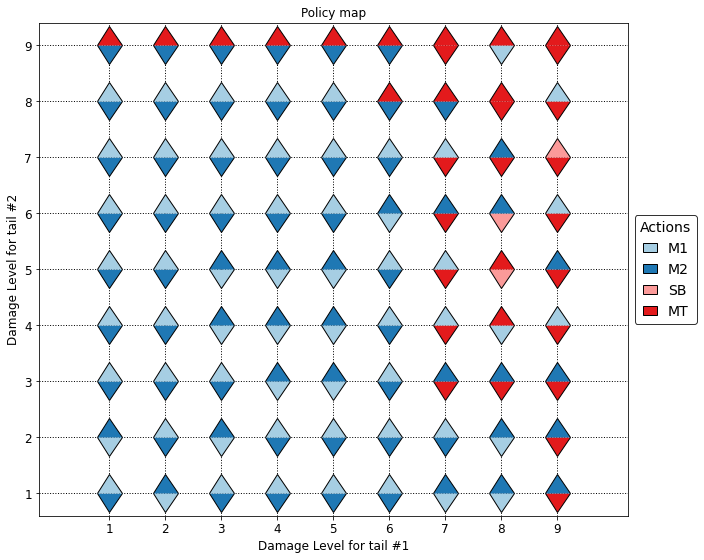

In [78]:
# load training parameters
fp = os.path.join(fp_init,'Qtable_run1')
with open(os.path.join(fp,'train_params.txt'),'r') as f:
    train_params = json.load(f)
step = train_params['saving_step']

# load last model
n_episodes = 2000
idx_model = n_episodes-1
fp_models = os.path.join(fp,'models')
# load Qtable
with open(os.path.join(fp_models,'qtable_%d.pkl'%idx_model),'rb') as f:
    q_table = pickle.load(f)
print('loaded model %d'%idx_model)

# load reward data
with open(os.path.join(fp,'train_stats.pkl'),'rb') as f:
    train_stats = pickle.load(f)
reward_per_episode = train_stats['reward']
# reward_per_episode2 = np.array(reward_per_episode.copy())
# reward_per_episode2[:int(1000/step)] = 0
# select optimal policy
# idx_max = (np.argmax(reward_per_episode2)+1)*step-1
# idx_max = 1999

# plot reward time-series
n_end = int(n_episodes/step)
fig,ax = plt.subplots(1,1,figsize=(10,5),tight_layout=True)
ax.grid(which='major',ls=':',c='k',lw=1)
indices = (np.arange(n_end)+1)*step-1
reward_per_episode = reward_per_episode[:n_end]
ax.plot(indices,reward_per_episode,'C0o-',ms=3)
ax.set(title='total reward per episode - reward = %d'%(reward_per_episode[-1]),
       xlabel='episodes',ylabel='total reward')
ax.plot(idx_model,reward_per_episode[-1],'ko',mfc='none')
fig.savefig(os.path.join(fp,'reward_per_episode.jpg'),dpi=200) 

# run one episode with optimal policy
env.reset()
damage_ts, reward_ts, qvals = opfleet.episode_qtable(q_table,env)
print('qtable -> total rewards = %d'%np.nansum(reward_ts))
# plot fleet status at last timestep
fig = env.fleet_status()
fig.savefig(os.path.join(fp,'status_final.jpg'))
# plot time-series
fig = opfleet.plot_damage_and_reward(damage_ts,reward_ts,env)
fig.savefig(os.path.join(fp,'ts_final.jpg'))

# visualise policy map (preferred action for each state)
fig,ax3 = plt.subplots(1,1,figsize=(10,8),tight_layout=True,)
ax3.grid(which='major',ls=':',c='k',lw=1)
colors = sns.color_palette('Paired',10)
colors_actions = [colors[0],colors[1],colors[4],colors[5]]
ax3.grid(which='major',ls=':',c='k',lw=1)
ax3.set(title='Policy map',
        xlabel='Damage Level for tail #1',xticks=np.arange(1,env.dlevels),
        ylabel='Damage Level for tail #2',yticks=np.arange(1,env.dlevels))
ax3.axis('equal')
for state in q_table:
    state_arr = np.fromstring(state[1:-1],dtype=int, sep=' ')
    best_action = np.nanargmax(q_table[state])
    action_pair = env.possible_actions[best_action]
    ax3.plot(state_arr[0],state_arr[1],marker=11,color=colors_actions[action_pair[0]],
                ms=25,mec='k')
    ax3.plot(state_arr[0],state_arr[1],marker=10,color=colors_actions[action_pair[1]],
                ms=25,mec='k')
handles = []
for k,key in enumerate(env.actions):
    handles.append(mpatches.Patch(fc=colors_actions[k],ec='k',label=key))
ax3.legend(handles=handles,loc='center left',fontsize=14,
          handlelength=1,edgecolor='k',bbox_to_anchor=[1,0.5],
          title='Actions')
fig.savefig(os.path.join(fp,'policy_map.jpg'))

## 3. Comparison to established strategies

To evaluate the performance of the optimal RL policy, baselines policies were designed using established fleet management methods:
- `on-condition maintenance`: in this policy preventive maintenance is assigned whenever an aircraft’s damage level passes a fixed threshold. This threshold was optimised by trial-and-error, and it was found to provide the highest reward when set at a damage level of 8/10. Outside of the maintenance zone, this policy always flies the prescribed missions and assigns them randomly to each tail number.
- `force-life management`: this policy assigns the missions so that the cumulated damage (i.e., crack length growth) is kept equal for each tail number in the fleet. For example, if tail #1 has a higher cumulated damage than tail #2, then in the next timestep the most damaging mission is assigned to tail #2.  Preventive maintenance is applied according to the on-condition maintenance strategy (when damage level is above 8).
- `equal-stress management`: this strategy is like force-life management but with a small distinction. The force-life management strategy assumes that we have perfect knowledge of the cumulated damage for each tail number. However, in a more realistic scenario we cannot record how much the crack propagated after each mission, but we do have knowledge on the missions that have were flown by each tail number. Thereby, the equal-stress policy calculates the “theoretical” cumulated stress range of each tail number (based on the missions it flew) and uses that metric to assign the missions rather than the cumulated crack length. The cumulated stress range associated with flying each mission is calculated as ($f0 \times dt \times ds$), where dt and ds vary according to the maneouvres that are completed.

### 3.1. Optimise the baseline policies by trial-and-error

The baseline policies depend on one parameter which is the damage level at which preventive maintenance should be assigned. To find damage level that provides the highest rewards for the baseline policies, we run episodes with each possible maintenance threshold and find the one that maximises the total rewards over the lifetime of the fleet.

9/10Optimum maintenance level for on-condition policy: damage level of 8
Optimum maintenance level for force-life policy: damage level of 8


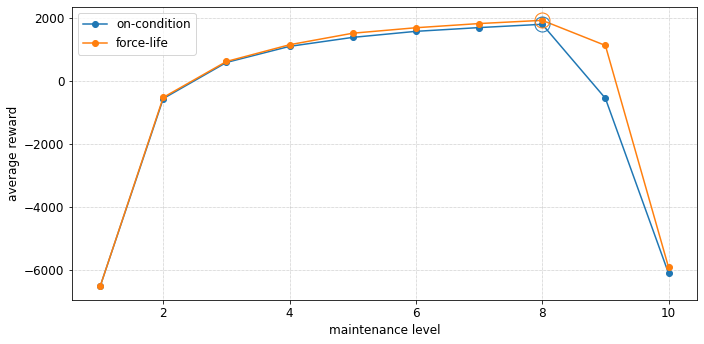

In [80]:
fp_base = os.path.join(fp_init,'baseline_policies')
if not os.path.exists(fp_base): os.makedirs(fp_base)

# optimise level at which maintenance is applied
repetitions = 30
if os.path.exists(os.path.join(fp_base,'oncondition_maintlevels.pkl')):
    with open(os.path.join(fp_base,'oncondition_maintlevels.pkl'),'rb') as f:
        data = pickle.load(f)
    maint_levels = data['maint_levels']
    total_rewards_oncond = data['rewards_oncond']
    total_rewards_forcelife = data['rewards_forcelife']
else:
    maint_levels = np.arange(1,env.dlevels+1,dtype=int)
    total_rewards_oncond = []
    total_rewards_forcelife = []
    for i,level in enumerate(maint_levels):
        print('\r%d/%d'%(i,len(maint_levels)),end='')
        # optimise on-condition maintenance
        rewards = 0
        for k in range(repetitions):
            env.reset()
            env.crack_lengths = np.random.uniform(env.a0*1000,env.amax*1000,env.n_tail)
            damage_levels = np.searchsorted(env.dintervals,env.crack_lengths,side='right')
            env.state[:env.n_tail] = damage_levels
            damage_ts, reward_ts = opfleet.episode_on_condition(env,maint_level=level)
            rewards += np.nansum(reward_ts)
        total_rewards_oncond.append(rewards/repetitions)
        # optimise force-life management
        rewards = 0
        for k in range(repetitions):
            env.reset()
            env.crack_lengths = np.random.uniform(env.a0*1000,env.amax*1000,env.n_tail)
            damage_levels = np.searchsorted(env.dintervals,env.crack_lengths,side='right')
            env.state[:env.n_tail] = damage_levels
            damage_ts, reward_ts = opfleet.episode_force_life(env,maint_level=level)
            rewards += np.nansum(reward_ts)
        total_rewards_forcelife.append(rewards/repetitions) 
    # store data in pickle file
    data = {'maint_levels':maint_levels,
            'rewards_oncond':total_rewards_oncond,
            'rewards_forcelife':total_rewards_forcelife}    
    with open(os.path.join(fp_base,'oncondition_maintlevels.pkl'),'wb') as f:
        pickle.dump(data,f)

# plot optimisation results
fig,ax = plt.subplots(1,1,figsize=[10,5],tight_layout=True); 
ax.grid(which='major',ls=':',c='0.5',lw=0.5)
ax.plot(maint_levels,total_rewards_oncond,'-o',label='on-condition')
ax.plot(maint_levels,total_rewards_forcelife,'-o',label='force-life')
ax.set(xlabel='maintenance level',ylabel='average reward')
ax.plot(maint_levels[np.argmax(total_rewards_oncond)],np.max(total_rewards_oncond),'C0o',mfc='None',ms=15)
ax.plot(maint_levels[np.argmax(total_rewards_forcelife)],np.max(total_rewards_forcelife),'C1o',mfc='None',ms=15)
ax.legend(loc='upper left')
fig.savefig(os.path.join(fp_base,'optim_results.jpg'))

maint_level_oncond = maint_levels[np.argmax(total_rewards_oncond)]
maint_level_forcelife = maint_levels[np.argmax(total_rewards_forcelife)]
print('Optimum maintenance level for on-condition policy: damage level of %d'%maint_level_oncond)
print('Optimum maintenance level for force-life policy: damage level of %d'%maint_level_forcelife)

### 3.2. Run 10,000 runs with each policy and plot reward distributions

To generate a distribution of rewards for each policy, we run 10,000 episodes for each policy varing the initial state of the fleet.

In [62]:
# run N simulations for each policy and compare the distributions
N = 10000
# initialise variables
reward_random = np.empty((N,env.n_tail))
reward_on_condition = np.empty((N,env.n_tail))
reward_force_life = np.empty((N,env.n_tail))
reward_equal_stress = np.empty((N,env.n_tail))
reward_RL = np.empty((N,env.n_tail))
completion_random = np.empty(N)
completion_on_condition = np.empty(N)
completion_force_life = np.empty(N)
completion_equal_stress = np.empty(N)
completion_RL = np.empty(N)
crack_lengths = np.empty((N,env.n_tail))
for k in range(env.n_tail):
    crack_lengths[:,k] = np.random.uniform(env.a0*1000,env.amax*1000,N)
# run sinmuls
for i in range(N):
    print('\repisode %d/%d'%(i+1,N),end='')
    # initial model policy
    env = opfleet.Env(params)
    env.crack_lengths = copy.deepcopy(crack_lengths[i,:])
    damage_levels = np.searchsorted(env.dintervals,env.crack_lengths,side='right')
    env.state[:env.n_tail] = damage_levels

    # random policy
    # env.reset()
    # env.crack_lengths = copy.deepcopy(crack_lengths[i,:])
    # damage_levels = np.searchsorted(env.dintervals,env.crack_lengths,side='right')
    # env.state[:env.n_tail] = damage_levels
    # damage_ts, reward_ts = opfleet.episode_random(env)
    # reward_random[i,:] = np.nansum(reward_ts,axis=0)
    # completion_random[i] = np.mean(env.availability)

    # on-condition maintenance
    env.reset()
    env.crack_lengths = copy.deepcopy(crack_lengths[i,:])
    damage_levels = np.searchsorted(env.dintervals,env.crack_lengths,side='right')
    env.state[:env.n_tail] = damage_levels
    damage_ts, reward_ts = opfleet.episode_on_condition(env,maint_level=maint_level_oncond)
    reward_on_condition[i,:] = np.nansum(reward_ts,axis=0)
    completion_on_condition[i] = np.mean(env.availability)

    # force-life management
    env.reset()
    env.crack_lengths = copy.deepcopy(crack_lengths[i,:])
    damage_levels = np.searchsorted(env.dintervals,env.crack_lengths,side='right')
    env.state[:env.n_tail] = damage_levels
    damage_ts, reward_ts = opfleet.episode_force_life(env,maint_level=maint_level_forcelife)
    reward_force_life[i,:] = np.nansum(reward_ts,axis=0)
    completion_force_life[i] = np.mean(env.availability)

    # equal-stress policy
    env.reset()
    env.crack_lengths = copy.deepcopy(crack_lengths[i,:])
    damage_levels = np.searchsorted(env.dintervals,env.crack_lengths,side='right')
    env.state[:env.n_tail] = damage_levels
    damage_ts, reward_ts = opfleet.episode_equal_stress(env,maint_level=maint_level_forcelife)
    reward_equal_stress[i,:] = np.nansum(reward_ts,axis=0)
    completion_equal_stress[i] = np.mean(env.availability)
    
    # RL policy
    env.reset()
    env.crack_lengths = copy.deepcopy(crack_lengths[i,:])
    damage_levels = np.searchsorted(env.dintervals,env.crack_lengths,side='right')
    env.state[:env.n_tail] = damage_levels
    damage_ts, reward_ts, qvals = opfleet.episode_qtable(q_table,env)
    reward_RL[i,:] = np.nansum(reward_ts,axis=0)
    completion_RL[i] = np.mean(env.availability)

# store into file
reward_all = {'random':reward_random,
              'on_condition':reward_on_condition,
              'force_life':reward_force_life,
              'equal_stress':reward_equal_stress,
              'RL':reward_RL}
with open(os.path.join(fp_init,'rewards_distributions.pkl'),'wb') as f:
    pickle.dump(reward_all,f)
completion_all = {'random':completion_random,
                  'on_condition':completion_on_condition,
                  'force_life':completion_force_life,
                  'equal_stress':completion_equal_stress,
                  'RL':completion_RL}
with open(os.path.join(fp_init,'completionrate_distributions.pkl'),'wb') as f:
    pickle.dump(completion_all,f)

episode 10000/10000

### 3.3. Plot reward distributions to evaluate RL policy

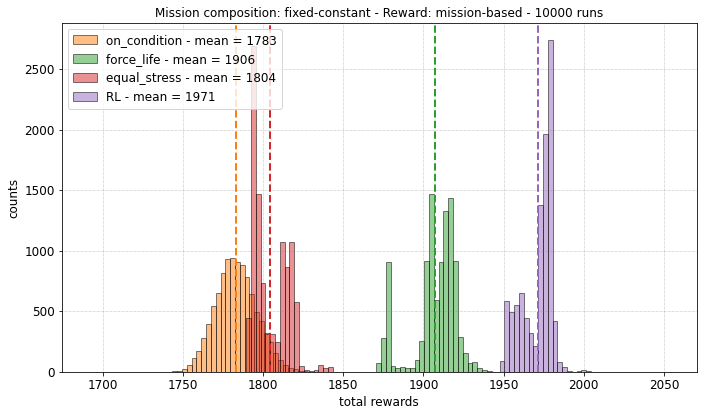

In [63]:
binwidth=3
with open(os.path.join(fp_init,'rewards_distributions.pkl'),'rb') as f:
    reward_all = pickle.load(f)
fig,ax=plt.subplots(1,1,figsize=[10,6],tight_layout=True); 
ax.grid(which='major',ls=':',c='0.5',lw=0.5)
# plot each distribution
for i,key in enumerate(reward_all.keys()):
    if key in ['random']: continue
    rewards = np.sum(reward_all[key],axis=1)
    bins = np.arange(np.min(rewards)-50,np.max(rewards)+50+binwidth,binwidth)-binwidth/2
    ax.hist(rewards,bins=bins,fc='C%d'%i,ec='k',label='%s - mean = %d'%(key,np.mean(rewards)),alpha=0.5)
    ax.axvline(np.mean(rewards),ls='--',lw=2,c='C%d'%i) 
ax.legend(loc='upper left'); 
ax.set(title='Mission composition: %s - Reward: %s - %d runs'%(params['mission_composition'],params['reward_scheme'],len(rewards)),
       xlabel='total rewards',ylabel='counts');
fig.savefig(os.path.join(fp,'policy_comparison_%d.jpg'%idx_max),dpi=200)